# Autocorrelation

## We define the relevant functions.
First, the function that returns the `mean values and stds` for x, y signal in Volts.

In [1]:
def P0_function(m_file):
       # if Path(filepath).stem == '_P0':
       P0_file = open(m_file/'_P0.txt', 'r')
       name_file = m_file.name
       P0 = pd.read_csv(P0_file, sep='\t', names=('tP0', 'x0', 'y0', 'z0'))
       x0 = P0['x0']
       y0 = P0['y0']
       #Fit value: mu, sigma from fitting gaussian in Volts:
       mu_x0 = (np.mean(x0))
       mu_y0 = (np.mean(y0))
       #sigma_V is the std in Volts given by the fitting of Gaussian on histogram in Python:
       sigma_V_x0 = np.std(x0)
       sigma_V_y0 = np.std(y0)
       return mu_x0, mu_y0, sigma_V_x0, sigma_V_y0, name_file

Then, we define a function that returns the `corner frequency` values for x and y as well as the `A values` and the `trap stiffness` values.

In [2]:
def corner_frequency_function(m_file, sigma_V_x0, sigma_V_y0):
       corner_frequency_file = open(m_file/'corner frequency.txt', 'r')
       #a is the bead radius in m:
       a = 4.95/2*10**(-6)

       #eta is the dynamic viscosity of the medium in [kg/ms]:
       eta = 0.000891

       #gamma is the friction coefficient of the medium [kg/s * um]:
       gamma = 6*np.pi*eta*a

       #units in [J * K^(-1)]:
       k_B = 1.3806488*(10**(-23))

       #T is the temperature in [K]:
       T = 293.15
       #f_c given by the power spectrum from MATLAB program is [Hz]:
       corner_frequency = pd.read_csv(corner_frequency_file, sep='\t', names=('fx', 'fy'))
       f_c_x0 = corner_frequency['fx']
       f_c_y0 = corner_frequency['fy']
       #kappa is the trap stifness:
       kappa_x0 = f_c_x0*2*np.pi*gamma
       kappa_y0 = f_c_y0*2*np.pi*gamma

       #sigma_m is the std in meters:
       sigma_m_x0 = np.sqrt(k_B*T/kappa_x0)
       sigma_m_y0 = np.sqrt(k_B*T/kappa_y0)

       #A is the conversion factor:
       A_x0 = sigma_m_x0/sigma_V_x0
       A_y0 = sigma_m_y0/sigma_V_y0
       return f_c_x0, f_c_y0, A_x0, A_y0, kappa_x0, kappa_y0

We import necessary libraries and define the total force function that returns a `dataframe with the total force`.

In [3]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

def total_force_function(m_file):
    # Then we pull a filopodium with the same bead and measure what happens in another time series.
    # for set up 4 a0 = xQPD, a2 = yQPD, a4 = zQPD
    # on set up 4, pulling happens along the y axis

    pulling_file = open(m_file/'pull_file.txt', 'r')
    P0_pull = pd.read_csv(pulling_file, sep=' ', names=('xQPD', 'xPiezo','yQPD', 'yPiezo', 'zQPD', 'zPiezo'), skiprows=range(0,11000))

    xQPD = P0_pull['xQPD'].loc[0:300000]
    yQPD = P0_pull['yQPD'].loc[0:300000]
    zQPD = P0_pull['zQPD'].loc[0:300000]
    xPiezo = P0_pull['xPiezo'].loc[0:300000]
    yPiezo = P0_pull['yPiezo'].loc[0:300000]
    zPiezo = P0_pull['zPiezo'].loc[0:300000]

    mu_x0 = P0_function(m_file)[0]
    mu_y0 = P0_function(m_file)[1]
    sigma_V_x0 = P0_function(m_file)[2]
    sigma_V_y0 = P0_function(m_file)[3]

    mux0df = [mu_x0]*len(xQPD)
    muy0df = [mu_y0]*len(yQPD)
    subtract_x = (xQPD - mux0df)
    subtract_y = (yQPD - muy0df)
    
    f_c_x0 = corner_frequency_function(m_file, sigma_V_x0, sigma_V_y0)[0]
    f_c_y0 = corner_frequency_function(m_file, sigma_V_x0, sigma_V_y0)[1]
    A_x0 = corner_frequency_function(m_file, sigma_V_x0, sigma_V_y0)[2]
    A_y0 = corner_frequency_function(m_file, sigma_V_x0, sigma_V_y0)[3]
    kappa_x0 = corner_frequency_function(m_file, sigma_V_x0, sigma_V_y0)[4]
    kappa_y0 = corner_frequency_function(m_file, sigma_V_x0, sigma_V_y0)[5]

    f_c_x0 = float(f_c_x0)
    f_c_y0 = float(f_c_y0)
    A_x0 = float(A_x0)
    A_y0 = float(A_y0)
    kappa_x0 = float(kappa_x0)
    kappa_y0 = float(kappa_y0)

    F_filopodium_x = -A_x0*kappa_x0*subtract_x*10**12
    F_filopodium_y = -A_y0*kappa_y0*subtract_y*10**12
    # The total force for filopodium
    Total_force_fil = (np.sqrt(F_filopodium_x**2 + F_filopodium_y**2))
    d = {'Total_force_fil':Total_force_fil}
    df = pd.DataFrame(d, columns = ['Total_force_fil'])  
    return df

We load the data.

In [4]:
filepath = Path('m5 (neutrophil 15 um)')

## Autocorrelation plots in different ways.
### Statsmodel ACF: plot_acf()
It uses the overall series sample mean and sample variance to determine the correlation coefficient.

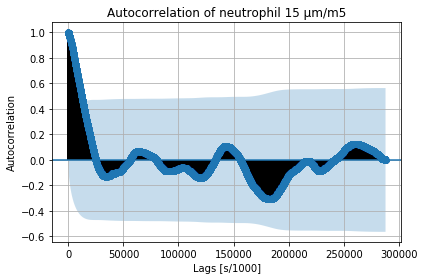

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, acf

nlags = 288000 # <----------- the number of lags that the series is shifted to itself (maximum 289000)
df = total_force_function(filepath)
plot_acf(df, lags = nlags, alpha = 0.05, title = 'Autocorrelation of neutrophil 15 μm/m5')
plt.xlabel('Lags [s/1000]')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()

### Matplotlib: acorr()
Mirrored with `unity set on zero lag`.
Manually subtracting the mean from the sample with detrend = mlab.detrend 

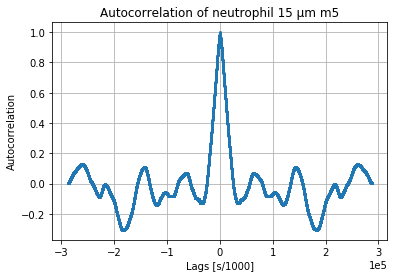

In [6]:
import matplotlib.mlab as mlab

filepath = Path('m5 (neutrophil 15 um)')
df = total_force_function(filepath)
signal = df['Total_force_fil']
nlags = 288000
plt.acorr(signal, normed=True, maxlags=nlags, usevlines = False, detrend=mlab.detrend, linestyle = ':', marker = 'o', linewidth = 1, markersize = 0.5)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.title('Autocorrelation of neutrophil 15 μm m5')
plt.xlabel('Lags [s/1000]')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

### acf() `not normalized` and plot_acf() `normalized`

Example with a Giant Plasma Membrane Vesicle - no actin and a neutrophil

/opt/conda/envs/python3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


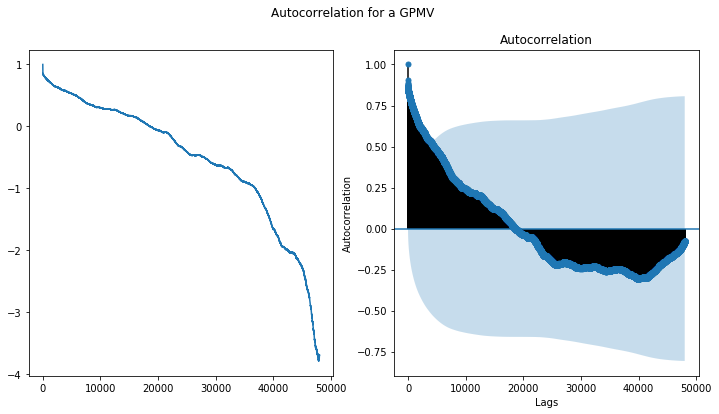

<Figure size 432x288 with 0 Axes>

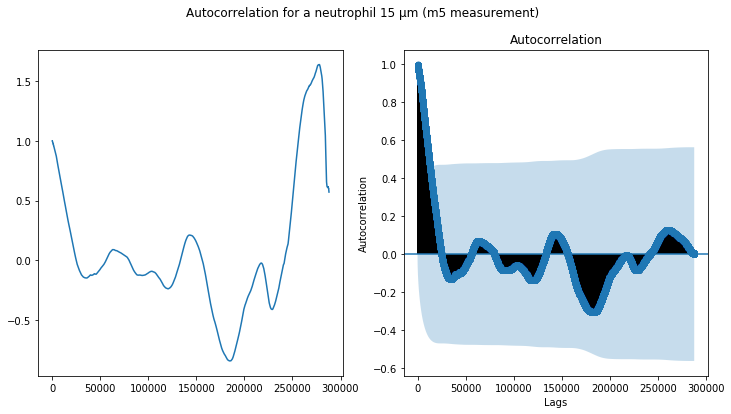

<Figure size 432x288 with 0 Axes>

In [7]:
filepath1 = Path('GPMV (15 um)')

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6), sharex=True, sharey=False)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
lags = 48000 # <----------- the number of lags that the series is shifted to itself
name_file1 = filepath1.name
df = total_force_function(filepath1)
t1 = df.Total_force_fil
#ax[0].title(name_file1)
a1 = acf(df, unbiased = True, nlags = lags - 1)
ax[0].plot(a1)
plot_acf(df, lags = lags, ax = ax[1])
plt.suptitle('Autocorrelation for a GPMV')
plt.show()
plt.tight_layout() # GM

filepath2 = Path('m5 (neutrophil 15 um)')

fig1, ax1 = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6), sharex=True, sharey=False)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
nlags1 = 288000 # <----------- the number of lags that the series is shifted to itself
name_file1 = filepath2.name
df = total_force_function(filepath2)
t1 = df.Total_force_fil
#ax[0].title(name_file1)
a1 = acf(df, unbiased = True, nlags = nlags1 - 1)
ax1[0].plot(a1)
plot_acf(df, lags = nlags1, ax = ax1[1])
plt.suptitle('Autocorrelation for a neutrophil 15 μm (m5 measurement)')
plt.show()
plt.tight_layout() # GM

### Finding the peaks for the autocorrelation.
There is the find_peaks function and I am `almost` done with it. My only issue is that plotting the peaks is not centered with my data. `Can you help?`

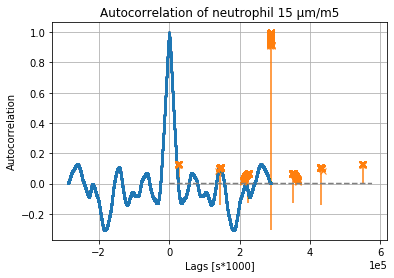

In [8]:
filepath2 = Path('m5 (neutrophil 15 um)')
nlags = 288000

df = total_force_function(filepath2)

signal = df['Total_force_fil']

sampling_frequency = 1000
lags, autocorr, line, b = plt.acorr(signal, normed=True, maxlags=nlags, usevlines = False, detrend=mlab.detrend, linestyle = ':', marker = 'o', linewidth = 1, markersize = 0.5)

from scipy.signal import find_peaks, peak_prominences, peak_widths

peaks, properties = find_peaks(autocorr, height= 0.0) # stating that a peak is significant if it has a lower limit of 0.0 (what should the height be?)
plt.plot(peaks, autocorr[peaks], 'x')
plt.plot(np.zeros_like(autocorr), "--", color="gray")

period =  peaks[0]/sampling_frequency

prominences = peak_prominences(autocorr, peaks)[0]
widths_heights = peak_widths(autocorr, peaks)[1]
widths = peak_widths(autocorr, peaks)[0]
left_ips = peak_widths(autocorr, peaks)[2][0]
right_ips = peak_widths(autocorr, peaks)[2][1]

plt.vlines(x = peaks, ymin = autocorr[peaks] - prominences, ymax = autocorr[peaks], color = 'C1')
plt.hlines(y = widths_heights, xmin = left_ips, xmax=right_ips, color = "C1")

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.title('Autocorrelation of neutrophil 15 μm/m5')
plt.xlabel('Lags [s*1000]')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()